# Geemap 教程（九）：农业环境

In [1]:
import ee
import geemap
ee.Initialize()
geemap.set_proxy(port="7890")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 提取研究区域所有 Landsat 影像

### 1.1 定义研究区域并将其可视化

In [3]:
TIGER = ee.FeatureCollection('TIGER/2018/Counties')
region = ee.Feature(TIGER.filter(ee.Filter.eq('STATEFP', '17')) \
                  .filter(ee.Filter.eq('NAME', 'McLean')) \
                  .first()).geometry()
Map = geemap.Map()
Map.centerObject(region)
Map.addLayer(region,{
   'color': 'red'
}, 'McLean County')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### 1.2 加载 Landsat 7 和 8 L2 级影像

In [4]:
landsat7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

### 1.3 重命名 Landsat 波段

In [5]:
def renameL7(img):
    img = img.rename([
        'BLUE', 'GREEN', 'RED', 'NIR',
        'SWIR1', 'SWIR2', 'TEMP1',
        'ATMOS_OPACITY', 'QA_CLOUD',
        'ATRAN', 'CDIST',
        'DRAD', 'EMIS', 'EMSD', 'QA', 'TRAD', 'URAD',
        'QA_PIXEL', 'QA_RADSAT'
    ])
    return img

def renameL8(img):
    img = img.rename([
        'AEROS',
        'BLUE', 'GREEN', 'RED', 'NIR',
        'SWIR1', 'SWIR2', 'TEMP1',
        'QA_AEROSOL',
        'ATRAN', 'CDIST',
        'DRAD', 'EMIS', 'EMSD', 'QA', 'TRAD', 'URAD',
        'QA_PIXEL', 'QA_RADSAT'
    ])
    return img

### 1.4  去云掩膜

In [6]:
def addMask(img):
    # Bit 0: Fill
    # Bit 1: Dilated Cloud
    # Bit 2: Cirrus (high confidence) (L8) or unused (L7)
    # Bit 3: Cloud
    # Bit 4: Cloud Shadow
    # Bit 5: Snow
    # Bit 6: Clear
    #        0: Cloud or Dilated Cloud bits are set
    #        1: Cloud and Dilated Cloud bits are not set
    # Bit 7: Water
    clear = img.select('QA_PIXEL').bitwiseAnd(64).neq(0)
    clear = clear.updateMask(clear).rename(['pxqa_clear'])

    water = img.select('QA_PIXEL').bitwiseAnd(128).neq(0)
    water = water.updateMask(water).rename(['pxqa_water'])

    cloud_shadow = img.select('QA_PIXEL').bitwiseAnd(16).neq(0)
    cloud_shadow = cloud_shadow.updateMask(cloud_shadow).rename([
       'pxqa_cloudshadow'
    ])

    snow = img.select('QA_PIXEL').bitwiseAnd(32).neq(0)
    snow = snow.updateMask(snow).rename(['pxqa_snow'])

    masks = ee.Image.cat([
       clear, water, cloud_shadow, snow
    ])
    return img.addBands(masks)

def maskQAClear(img):
    return img.updateMask(img.select('pxqa_clear'))

### 1.5 计算并添加 GCVI 波段

In [7]:
def addGCVI(img):
    gcvi = img.expression(
        '(nir / green) - 1',
        {
            'nir': img.select('NIR'),
            'green': img.select('GREEN')
        }).select([0], ['GCVI'])
    return ee.Image.cat([img, gcvi])

### 1.6 筛选数据

In [8]:
start_date = '2020-01-01'
end_date = '2020-12-31'

# 筛选出起止日期间研究区域的Landsat 7 和 8 数据
landsat7coll = landsat7.filterBounds(region) \
    .filterDate(start_date, end_date) \
    .map(renameL7)

landsat8coll = landsat8.filterBounds(region) \
    .filterDate(start_date, end_date) \
    .map(renameL8)

In [9]:
landsat = landsat7coll.merge(landsat8coll) \
    .sort('system:time_start')

# 屏蔽不清晰的像素，添加 GCVI 和 time 变量
landsat = landsat.map(addMask) \
    .map(maskQAClear) \
    .map(addGCVI)

### 1.7 图表可视化

In [10]:
point = ee.Geometry.Point([
    -88.81417685576481,
    40.579804398254005
])

In [11]:
# 定义一个函数，用于对每个影像该点的 GCVI 值
# 并返回一个包含 GCVI 值和时间属性的Feature
def get_gcvi_and_date(image):
    # 获取某一点上的 GCVI 值
    gcvi = image.select('GCVI').reduceRegion(ee.Reducer.first(), point)
    # 获取影像的日期，使用ee.Date()方法，并格式化为YYYY-MM-dd
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    # 返回一个包含 GCVI 值和时间属性的要素
    return ee.Feature(point, {'date': date, 'gcvi': gcvi})

# 使用ee.ImageCollection.map()方法来对影像集合中每个影像应用上面定义的函数
# map()函数返回的是一个ee.ComputedObject类型的对象
# 需要将结果转化为ee.FeatureCollection
gcvi_val = ee.FeatureCollection(landsat.map(get_gcvi_and_date))

In [12]:
df = geemap.ee_to_pandas(gcvi_val)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# 使用apply()方法来获取每个字典中的GCVI值
df['gcvi'] = df['gcvi'].apply(lambda x: x['GCVI'])
# 将gcvi列中的空值设置为NaN
df['gcvi'] = df['gcvi'].replace('', np.nan)
GCVI_output = './output/gcvi_chart.xlsx'
df.to_excel(GCVI_output, index=False)

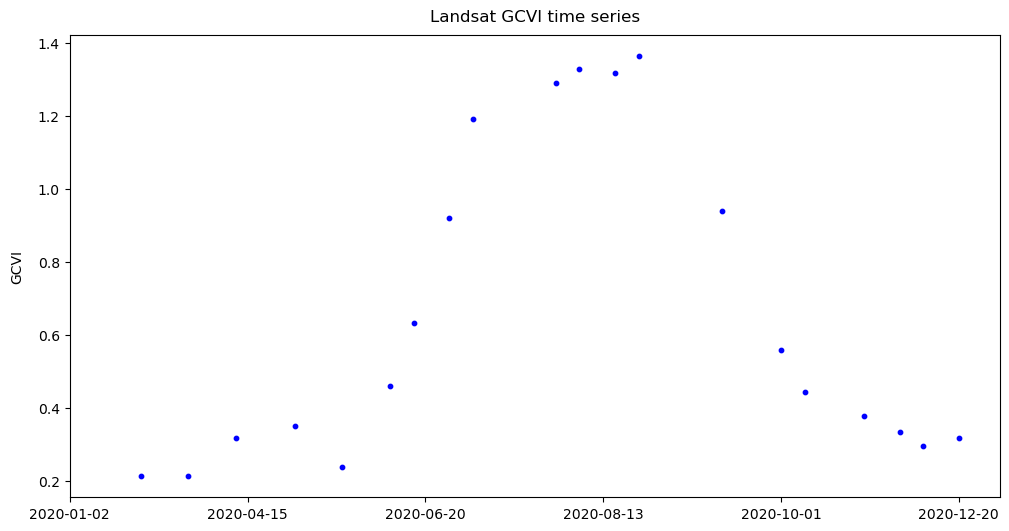

In [13]:
GCVI_df = pd.read_excel(GCVI_output)

plt.figure(figsize=(12, 6))
GCVI_df['date'] = GCVI_df['date'].dt.strftime('%Y-%m-%d')
# 将gcvi列中的空值设置为NaN
GCVI_df['gcvi'] = GCVI_df['gcvi'].replace('', np.nan)

# 绘制散点折线图，使用日期作为x轴，GCVI值作为y轴，设置散点大小为10
plt.scatter(GCVI_df['date'], GCVI_df['gcvi'], color='blue', s=10)
plt.ylabel('GCVI', labelpad=10)
plt.xticks(np.arange(0, len(df), 15))
plt.title('Landsat GCVI time series', pad=10)

# 保存图形为一个png文件，分辨率为300dpi，要放在图像绘制之前
out_file = "./output/Landsat_GCVI_time_series.png"
plt.savefig(out_file, dpi=300)
plt.show()

### 1.8 获取作物类型数据集

In [14]:
cdl = ee.Image('USDA/NASS/CDL/2020').select(['cropland'])
Map.addLayer(cdl.clip(region), {}, 'CDL 2020')
Map

Map(bottom=99047.0, center=[40.51926422440161, -88.86431136556666], controls=(WidgetControl(options=['position…

## 2 向 Landsat 影像添加进行谐波回归后的波段

### 2.1 为图像添加时间带

In [15]:
def addTimeUnit(image, refdate):
   date = image.date()
   dyear = date.difference(refdate, 'year')
   t = image.select(0).multiply(0).add(dyear).select([0], ['t']).float()
   imageplus = image.addBands(t)
   return imageplus

### 2.2 向图像添加谐波基的

In [18]:
import math

In [21]:
def addHarmonics(image, omega, refdate):
    image = addTimeUnit(image, refdate)
    timeRadians = image.select('t').multiply(2 * math.pi * omega)
    timeRadians2 = image.select('t').multiply(4 * math.pi * omega)

    return image.addBands(timeRadians.cos().rename('cos')) \
        .addBands(timeRadians.sin().rename('sin')) \
        .addBands(timeRadians2.cos().rename('cos2')) \
        .addBands(timeRadians2.sin().rename('sin2')) \
        .addBands(timeRadians.divide(timeRadians).rename('constant'))

In [22]:
omega = 1
def use_addHarmonics(image):
    return addHarmonics(image, omega, start_date)
landsatPlus = landsat.map(use_addHarmonics)
print('Landsat collection with harmonic basis: ', landsatPlus)

Landsat collection with harmonic basis:  ee.ImageCollection({
  "functionInvocationValue": {
    "functionName": "Collection.map",
    "arguments": {
      "baseAlgorithm": {
        "functionDefinitionValue": {
          "argumentNames": [
            "_MAPPING_VAR_0_0"
          ],
          "body": {
            "functionInvocationValue": {
              "functionName": "Image.addBands",
              "arguments": {
                "dstImg": {
                  "functionInvocationValue": {
                    "functionName": "Image.addBands",
                    "arguments": {
                      "dstImg": {
                        "functionInvocationValue": {
                          "functionName": "Image.addBands",
                          "arguments": {
                            "dstImg": {
                              "functionInvocationValue": {
                                "functionName": "Image.addBands",
                                "arguments": {
             